In [1]:
from importlib.metadata import version

print(version("torch"))
print(version("tiktoken"))

2.8.0+cu126
0.12.0


In [2]:
with open("/content/the-verdict.txt","r",encoding="utf-8") as f:
  raw_text=f.read()
print("total number of characters",len(raw_text))
print(raw_text[:99])

total number of characters 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


tokenization

In [3]:
import re
preprocessed=re.split(r'([,.:;?_!"()\']|--|\s)',raw_text)
preprocessed=[item for item in preprocessed if item]
print(preprocessed[:38])

['I', ' ', 'HAD', ' ', 'always', ' ', 'thought', ' ', 'Jack', ' ', 'Gisburn', ' ', 'rather', ' ', 'a', ' ', 'cheap', ' ', 'genius', '--', 'though', ' ', 'a', ' ', 'good', ' ', 'fellow', ' ', 'enough', '--', 'so', ' ', 'it', ' ', 'was', ' ', 'no', ' ']


In [4]:
print("Number of tokens",len(preprocessed))

Number of tokens 8405


In [5]:
#unique tokens
len(set(preprocessed))

1132

converting to token ids

In [6]:
#we are taking unique tokens and mapping them to unique token ids
all_words=sorted(set(preprocessed))
vocab_size=len(all_words)

print(vocab_size)

1132


In [7]:
vocab={token:integer for integer,token in enumerate(all_words)}

In [8]:
for i,item in enumerate(vocab.items()):
  print(item)
  if i>50:
    break

('\n', 0)
(' ', 1)
('!', 2)
('"', 3)
("'", 4)
('(', 5)
(')', 6)
(',', 7)
('--', 8)
('.', 9)
(':', 10)
(';', 11)
('?', 12)
('A', 13)
('Ah', 14)
('Among', 15)
('And', 16)
('Are', 17)
('Arrt', 18)
('As', 19)
('At', 20)
('Be', 21)
('Begin', 22)
('Burlington', 23)
('But', 24)
('By', 25)
('Carlo', 26)
('Chicago', 27)
('Claude', 28)
('Come', 29)
('Croft', 30)
('Destroyed', 31)
('Devonshire', 32)
('Don', 33)
('Dubarry', 34)
('Emperors', 35)
('Florence', 36)
('For', 37)
('Gallery', 38)
('Gideon', 39)
('Gisburn', 40)
('Gisburns', 41)
('Grafton', 42)
('Greek', 43)
('Grindle', 44)
('Grindles', 45)
('HAD', 46)
('Had', 47)
('Hang', 48)
('Has', 49)
('He', 50)
('Her', 51)


a combined class form of simple tokenizer

In [9]:
import re

class simpletokenizerv1:
  def __init__(self,vocab):
    self.str_to_int=vocab#the dictionary that we created
    self.int_to_str={i:s for s,i in vocab.items()}
  def encode(self,text):
    preprocessed=re.split(r'([,.?_!"()\']|--|\s)',text)
    preprocessed=[item.strip() for item in preprocessed if item.strip()]
    ids=[self.str_to_int[s] for s in preprocessed]
    return ids
  def decode(self,ids):
    text=" ".join([self.int_to_str[i] for i in ids])
    text=re.sub(r'\s+([,.?!"()\'])', r'\1', text)
    return text

In [10]:
tokenizer = simpletokenizerv1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[3, 58, 4, 852, 990, 604, 535, 748, 7, 1128, 598, 7, 3, 69, 9, 40, 853, 1110, 756, 795, 9]


In [12]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

byte pair encoding

In [13]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.12.0


In [14]:
tokenizer = tiktoken.get_encoding("gpt2")

In [15]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})#we have to specifically mention the endoftext inspite of the reason that it is compulsary in gpt like modes to have endoftext token

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [16]:
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


In [17]:
#it can encode new words as well
tokenizer.encode("Akwirw ier", allowed_special={"<|endoftext|>"})


[33901, 86, 343, 86, 220, 959]

creating dataloader using the sliding window approach

In [18]:
import torch
import tiktoken
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [19]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


#**GPT Architecture**

In [20]:
GPT_CONFIG_124M={
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.0,
    "qkv_bias":False
}

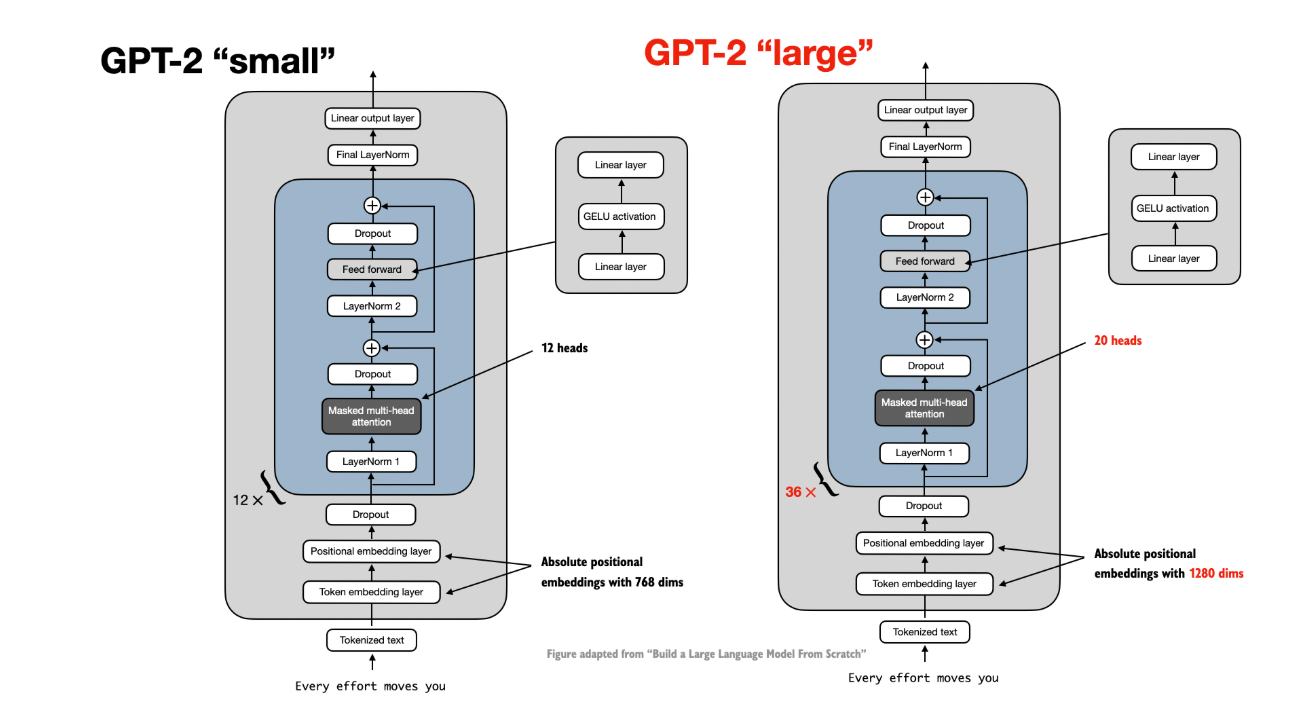

whole coding block

In [22]:
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [23]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [24]:
import torch
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 6.4165e-02,  2.0443e-01, -1.6945e-01,  ...,  1.7887e-01,
           2.1921e-01, -5.8153e-01],
         [ 3.7736e-01, -4.2545e-01, -6.5874e-01,  ..., -2.5050e-01,
           4.6553e-01, -2.5760e-01],
         [ 8.8996e-01, -1.3770e-01,  1.4748e-01,  ...,  1.7770e-01,
          -1.2015e-01, -1.8902e-01],
         [-9.7276e-01,  9.7338e-02, -2.5419e-01,  ...,  1.1035e+00,
           3.7639e-01, -5.9006e-01]],

        [[ 6.4165e-02,  2.0443e-01, -1.6945e-01,  ...,  1.7887e-01,
           2.1921e-01, -5.8153e-01],
         [ 1.3433e-01, -2.1289e-01, -2.7021e-02,  ...,  8.1153e-01,
          -4.7410e-02,  3.1186e-01],
         [ 8.9996e-01,  9.5396e-01, -1.7896e-01,  ...,  8.3053e-01,
           2.7657e-01, -2.4577e-02],
         [-9.3430e-05,  1.9390e-01,  5.1217e-01,  ...,  1.1915e+00,
          -1.6431e-01,  3.7046e-02]]], grad_fn=<UnsafeViewBackward0>)


In [26]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [27]:
model.eval();  # disable dropout

In [28]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [29]:
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [30]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)


Hello, I am Featureiman Byeswickattribute argue
